#**AYKIRI GÖZLEM ANALİZİ**

---



Veride genel eğilimin oldukça dışına çıkan yad adiğer gözlemlerden oldukça farklı olan gözlemlere aykırı gözlem denir. 

**Aykırı Değer Nedir?**

Aykırılığı ifade eden nümerik değere denir.

**Aykırı Gözlem Nedir?**

Aykırı değeri barındıran gözlem birimine denir. (Bir satır gibi)

#**1. Tek Değişkenli Aykırı Gözlem Analizi**

---

##**1.1 Sorgulamak ve Yakalamak**

In [0]:
import seaborn as sns
diamonds=sns.load_dataset("diamonds")
df=diamonds.copy()
df=df.select_dtypes(include=["float64","int64"]) #İçinden sadece sürekli değişkenleri seçiyoruz.
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


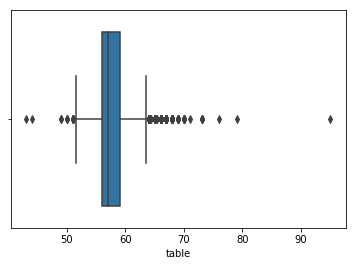

In [0]:
df_table=df["table"].copy() #table kolonu için aykırı gözlem analizi yapacağız.
sns.boxplot(x=df_table)

In [0]:
#Eşik değerlerin hesaplanması için
Q1=df_table.quantile(0.25) #ilk %25 lik değer
Q3=df_table.quantile(0.75) #ilk %75 lik değer
IQR=Q3 - Q1

alt_sinir=Q1 - 1.5*IQR #Alt sınır eşik değeri hesaplama işlemi
alt_sinir

ust_sinir=Q3 + 1.5*IQR #Üst sınır
ust_sinir

63.5

In [0]:
(df_table<(alt_sinir)) | (df_table>(ust_sinir)) #Vektör düzeyinde Aykırı değer sorgulaması

In [0]:
df_table<(alt_sinir)

In [0]:
aykiri_tf=df_table<(alt_sinir)
type(aykiri_tf) #Series.
aykiri_tf[0:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: table, dtype: bool

In [0]:
aykirilar=df_table[aykiri_tf] #Burda çıkanlar Aykırı Gözlemlerimiz. DataFrame e göndererek Sorguluyor
print(aykirilar)
print(aykirilar.index)

1515     51.0
3238     50.1
3979     51.0
4150     51.0
5979     49.0
7418     50.0
8853     51.0
11368    43.0
22701    49.0
25179    50.0
26387    51.0
33586    51.0
35633    44.0
45798    51.0
46040    51.0
47630    51.0
Name: table, dtype: float64
Int64Index([ 1515,  3238,  3979,  4150,  5979,  7418,  8853, 11368, 22701,
            25179, 26387, 33586, 35633, 45798, 46040, 47630],
           dtype='int64')


##**1.2 Aykırı Değer Probleminin Çözülmesi**

###**1.2.1 Aykırı Değerleri Silmek**



In [0]:
import pandas as pd
df_table.head()
type(df_table)
df_table.shape

(53940,)

In [0]:
temiz_df_table=df_table[~((df_table < (alt_sinir)) | (df_table>(ust_sinir)))] #Temizleme İşlemi

In [0]:
temiz_df_table.shape

(53335,)

###**1.2.2 Aykırı Değerleri Ortalama ile Doldurmak**

In [0]:
df_table=df["table"].copy()

In [0]:
aykiri_tf=(df_table<(alt_sinir)) | (df_table>(ust_sinir))
df_table[aykiri_tf].head()

2      65.0
91     69.0
145    64.0
219    64.0
227    67.0
Name: table, dtype: float64

In [0]:
df_table.mean()

57.45718390804603

In [0]:
df_table[aykiri_tf]=df_table.mean()

In [0]:
df_table[aykiri_tf].head()

2      57.457184
91     57.457184
145    57.457184
219    57.457184
227    57.457184
Name: table, dtype: float64

###**1.2.3 Aykırı Değerleri Baskılama Yöntemi ile Doldurmak**

Aykırı gözlmelerin tam olarak aykırı olamayabileceği yada veri setinni bu aykırılıkları da göz önünde bulundurmasını istiyorsak kullanılır.

In [0]:
df_table[aykiri_tf].head()

2      57.457184
91     57.457184
145    57.457184
219    57.457184
227    57.457184
Name: table, dtype: float64

In [0]:
df_table[aykiri_tf]=alt_sinir #Alt sınıra baskılamış olduk

#**2. Çok Değişkenli Aykırı Gözlem Analizi**

---



##**2.1 LOF Teorisi ve Yapay Veri Seti Oluşturma**

Local Outlier Factor(LOF)
Aykırı Değer olabilme durumunu gözlemlerin etraflarındaki yoğunluklara göre karşılaştırıyor. Bir noktanın lokal yoğunluğu o noktanın komşularıyla karşılaştırılıyor. Komşu yoğunluğundan düşük ise komşularından daha seyre kbir bölgede bulunuyordur yorumu yapıyor.
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/LOF-idea.svg/250px-LOF-idea.svg.png)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42) #Oluşturulacak olan sayıların sabit olmasını sağlıyoruz.
X_inliers=np.random.normal(70,3, (100,2)) #Ortalaması 70 Standart sapması 3 olan veri seti oluşturma

X_inliers=np.r_[X_inliers + 10, X_inliers - 10] #r_ --> index problemine takılmadan daha hızlı array oluşturmak için kullanılır

print(X_inliers.shape)
print(X_inliers[:3,:2])


(200, 2)
[[81.49014246 79.5852071 ]
 [81.94306561 84.56908957]
 [79.29753988 79.29758913]]


In [0]:
X_outliers=np.random.uniform(low=15, high=130, size=(20, 2))
X_outliers

array([[115.89790327, 100.18839104],
       [ 95.15681021,  95.78566966],
       [ 56.34148239,  48.76306209],
       [108.07653288, 108.16304039],
       [114.71331664, 120.02266354],
       [ 73.80437587,  72.67437389],
       [106.80394558,  89.74585204],
       [ 95.72619088, 106.51615699],
       [117.35061431,  53.86944304],
       [ 58.19203955,  25.80792308],
       [ 81.50221621,  19.13336149],
       [ 68.54377209,  77.40413299],
       [ 47.95224399,  82.94582497],
       [ 18.50752874,  19.29504171],
       [109.59906448,  56.42192376],
       [ 29.61195895,  75.05797491],
       [103.54925861,  39.81941816],
       [ 86.63240472,  24.81495847],
       [ 20.94339793,  76.10578263],
       [ 77.17303899,  88.30443867]])

In [0]:
X=np.r_[X_inliers,X_outliers] #Birleştirme
X[0:3,:]

array([[81.49014246, 79.5852071 ],
       [81.94306561, 84.56908957],
       [79.29753988, 79.29758913]])

In [0]:
LOF=LocalOutlierFactor(n_neighbors=20,contamination=0.1)

In [0]:
LOF.fit_predict(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [0]:
X_score=LOF.negative_outlier_factor_ #Skor Hesabı Yaptık
X_score[0:3]

array([-0.99920793, -1.14732911, -0.97212675])

In [0]:
X_score.mean()

-1.6850227435158005

In [0]:
X_score.std()

2.140119050235338

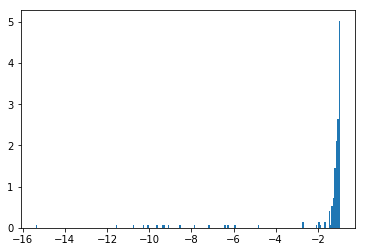

In [0]:
plt.hist(X_score,bins="auto",density=True)
plt.show()
#Her gözlem için skor hesabı yaptık. Skorların yüksek olması aykırı gözlemi ifade eder.

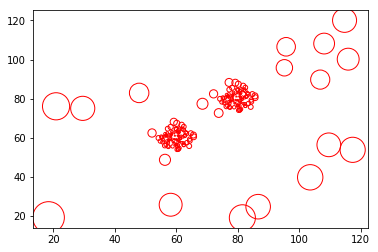

In [0]:
radius=(X_score.max() - X_score) / (X_score.max() - X_score.min())
plt.scatter(X[:,0],X[:,1],s=1000*radius, edgecolor="r", facecolors="none",label="LOF Skorları")

##**2.2 Aykırı Gözlemleri Yakalamak**

In [0]:
X[0:3]

array([[81.49014246, 79.5852071 ],
       [81.94306561, 84.56908957],
       [79.29753988, 79.29758913]])

In [0]:
np.sort(X_score)[0:9] #Sıralı halde LOF skorlarını getirdik.

array([-15.3785652 , -11.57669644, -10.75276599, -10.24101046,
       -10.07364152,  -9.64406264,  -9.34229978,  -9.26256027,
        -9.06812573])

In [0]:
esik_deger=np.sort(X_score)[9] #10. değeri eşik değer yapmak istiyoruz diyelim.
esik_deger

-8.512759037993277

In [0]:
(X_score > esik_deger)[200:220] #Eşik değeri ile skorlarda sorgulama yaptık.

array([ True,  True,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True])

In [0]:
tf_vektor=(X_score > esik_deger)

In [0]:
X[(X_score > esik_deger)] # Aykırı olmayan gözlemleri verir.  < yaparsak aykırı gözlemlere erişiriz.

In [0]:
X[(X_score < esik_deger)] #Aykırı gözlemleri verir.

##**2.3 Aykırı Gözlem Problemini Çözmek**

###**2.3.1 Aykırı Gözlemleri Silmek**

In [0]:
df=X[X_score > esik_deger] #Eşik değerinden büyük olanları atayarak aykırı gözlemleri silmiş oluyoruz.

In [0]:
df[0:10]

array([[81.49014246, 79.5852071 ],
       [81.94306561, 84.56908957],
       [79.29753988, 79.29758913],
       [84.73763845, 82.30230419],
       [78.59157684, 81.62768013],
       [78.60974692, 78.60281074],
       [80.72588681, 74.26015927],
       [74.8252465 , 78.31313741],
       [76.96150664, 80.942742  ],
       [77.27592777, 75.7630889 ]])

###**2.3.2 Aykırı Gözlemleri Ortalamayla Doldurma**

In [0]:
df_X=X.copy()

In [0]:
np.mean(df_X[0])
np.mean(df_X[1])

83.25607759176307

In [0]:
aykirilar=df_X[~tf_vektor]

In [0]:
aykirilar[:,:1]

array([[80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478],
       [80.53767478]])

In [0]:
aykirilar[:,:1]=np.mean(df_X[0])

In [0]:
aykirilar[:,1:2]=np.mean(df_X[1])

In [0]:
aykirilar

array([[80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759],
       [80.53767478, 83.25607759]])

In [0]:
df_X[~tf_vektor]=aykirilar

###**2.3.3 Aykırı Gözlemleri Baskılama ile Değiştirmek**

In [0]:
df_X=X.copy()

In [0]:
df_X[X_score == esik_deger]

array([[58.19203955, 25.80792308]])

In [0]:
df_X[~tf_vektor]=df_X[X_score == esik_deger]

In [0]:
df_X[~tf_vektor]

array([[58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308],
       [58.19203955, 25.80792308]])

#EKSİK VERİ ANALİZİ

---



##**1. Eksik Veri Hızlı Çözüm**


In [4]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
df=pd.DataFrame(
    {"V1":V1,
     "V2":V2,
     "V3":V3} 
)
df

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
2,6.0,5.0,5.0
3,NaN,8.0,6.0
4,7.0,12.0,14.0
5,1.0,NaN,7.0
6,NaN,NaN,NaN
7,9.0,2.0,2.0
8,15.0,3.0,3.0


In [6]:
df.isnull().sum() #Her sütundaki eksik değerleri buluyoruz.

V1    2
V2    3
V3    2
dtype: int64

###**1.1 Eksik Veriyi Direk Silmek**

In [7]:
df.dropna() #Satırda 1 tane bile eksik gözlem var ise o satırı siler.
#Kalıcı yapmak için ya başka değişkene atarız yada
#df.dropna(inplace=True) #Başka değişkene atama yapmadan

,V1,V2,V3
2,6.0,5.0,5.0
4,7.0,12.0,14.0
7,9.0,2.0,2.0
8,15.0,3.0,3.0


###**1.2 Basit Değer Atama ile Doldurmak**

In [0]:
df["V1"].mean()

In [0]:
df["V1"].fillna(df["V1"].mean()) #Ortalama değer ile Eksik Değerleri dolduruyor. fillna()

In [0]:
df["V1"].fillna(0) # 0 Sıfır ile doldurma.

In [11]:
df.apply(lambda x: x.fillna(x.mean()),axis=0) #Sütunlarda gezerek herbirini ortalama ile doldur.

,V1,V2,V3
0,1.0,7.000000,7.0
1,3.0,6.166667,12.0
2,6.0,5.000000,5.0
3,6.0,8.000000,6.0
4,7.0,12.000000,14.0
5,1.0,6.166667,7.0
6,6.0,6.166667,7.0
7,9.0,2.000000,2.0
8,15.0,3.000000,3.0


##**2. Eksik Veri Saptama**

In [12]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
df=pd.DataFrame(
    {"V1":V1,
     "V2":V2,
     "V3":V3} 
)
df

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
2,6.0,5.0,5.0
3,NaN,8.0,6.0
4,7.0,12.0,14.0
5,1.0,NaN,7.0
6,NaN,NaN,NaN
7,9.0,2.0,2.0
8,15.0,3.0,3.0


In [13]:
df.dtypes

V1    float64
V2    float64
V3    float64
dtype: object

In [14]:
df.notnull().sum() #Değişkenlerdeki Tam Değer sayısına ulaşıyor.

V1    7
V2    6
V3    7
dtype: int64

In [15]:
df.isnull().sum() #Eksik değer sayısına ulaşma.

V1    2
V2    3
V3    2
dtype: int64

In [16]:
df.isnull()

,V1,V2,V3
0,False,False,True
1,False,True,False
2,False,False,False
3,True,False,False
4,False,False,False
5,False,True,False
6,True,True,True
7,False,False,False
8,False,False,False


In [17]:
#En az 1 tane eksik değer içeren tüm gözlemlere ulaşma.
df[df.isnull().any(axis=1)]

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
3,NaN,8.0,6.0
5,1.0,NaN,7.0
6,NaN,NaN,NaN


In [19]:
df[df.notnull().all(axis=1)]

,V1,V2,V3
2,6.0,5.0,5.0
4,7.0,12.0,14.0
7,9.0,2.0,2.0
8,15.0,3.0,3.0


##**3. Eksik Veri Görselleştirme**

In [0]:
!pip install missingno

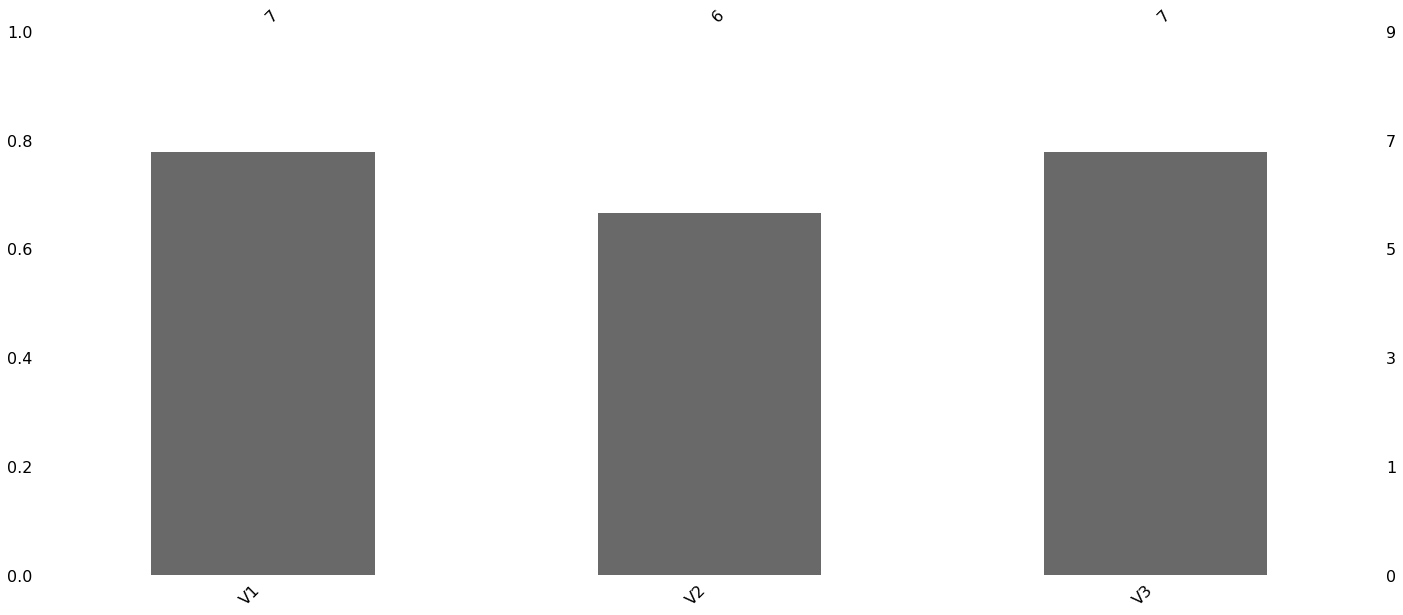

In [23]:
import missingno as msno
msno.bar(df)

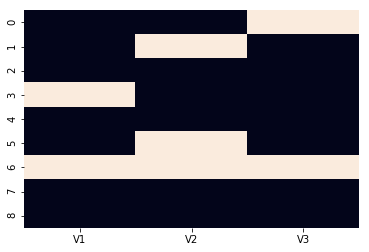

In [24]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False);

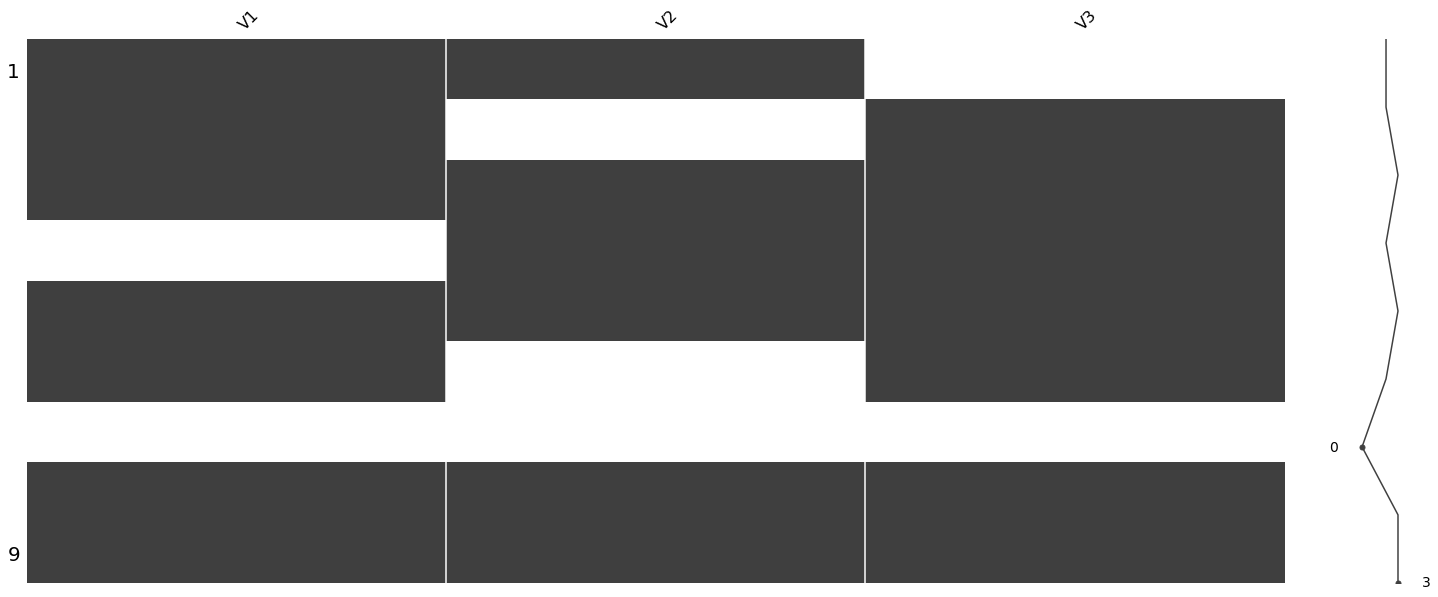

In [26]:
msno.matrix(df)

In [27]:
df=sns.load_dataset("planets").copy()
df.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


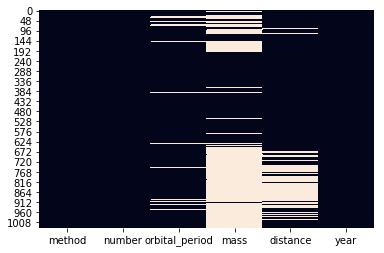

In [28]:
sns.heatmap(df.isnull(),cbar=False)

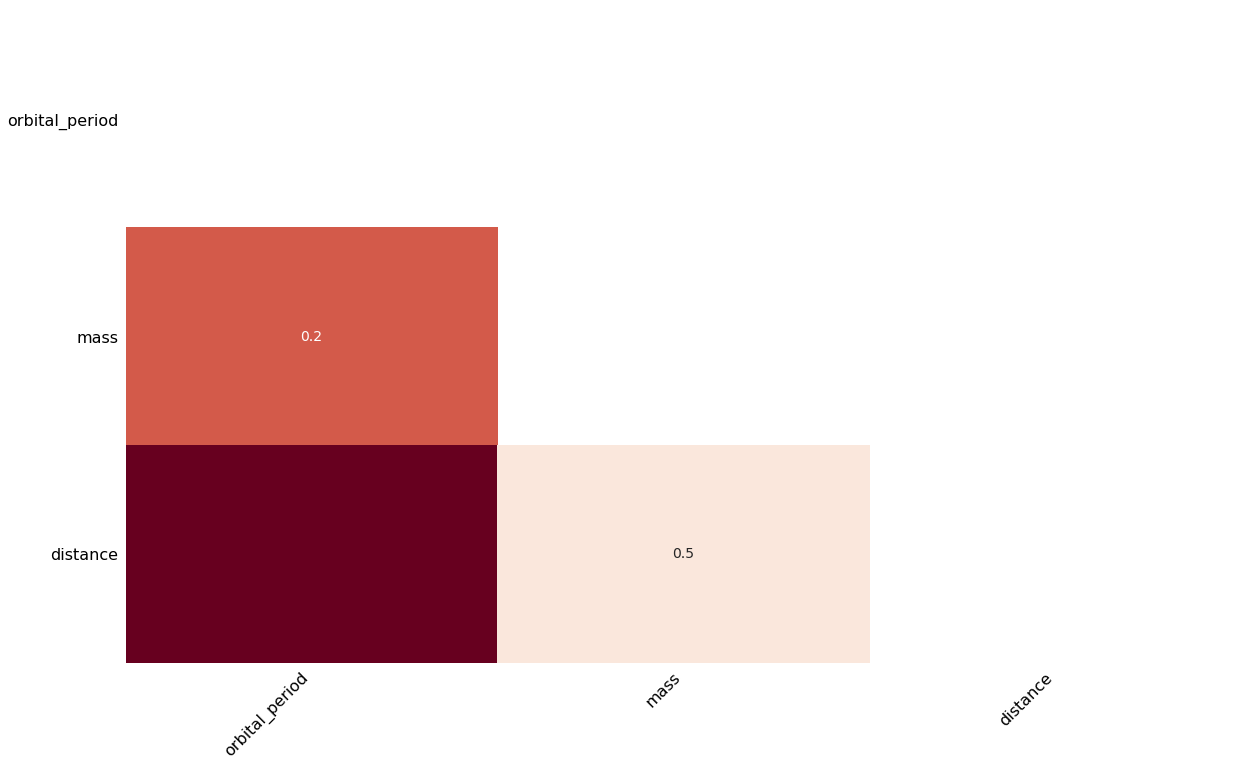

In [29]:
msno.heatmap(df)
#Kendisinde eksiklik olan değişkenlerin birbirlerini etkileme şekillerini inceleme adına bu heatmap i kullanabiliyoruz.
#Nullity Correlation
#0.1 - 1 arasında birlikte görme yüzdeleri veriyor.
#-1 ise kesinlikle bir bağlantı yok anlamına gelir.

In [0]:
#Zaman serisi üzerindeki Eksikliği Yakalama


##**3. Eksik Veri Silme Yöntemleri**

In [0]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
df=pd.DataFrame(
    {"V1":V1,
     "V2":V2,
     "V3":V3} 
)
df

In [0]:
df.dropna()

###**3.1 Tüm Gözlem Değerleri Aynı Anda Na Olan Gözlem Değerlerini Silme**

In [32]:
df.dropna(how="all")

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
2,6.0,5.0,5.0
3,NaN,8.0,6.0
4,7.0,12.0,14.0
5,1.0,NaN,7.0
7,9.0,2.0,2.0
8,15.0,3.0,3.0


###**3.2 En az 1 Tane Eksik Değere Sahip Sütunun Silinmesi**

In [0]:
df.dropna(axis=1)

In [0]:
df["V1"][3,6,]=99

In [34]:
df.dropna(axis=1)

,V1
0,1.0
1,3.0
2,6.0
3,99.0
4,7.0
5,1.0
6,99.0
7,9.0
8,15.0


###**3.3 Tüm Değerleri Na olan Sütunu Silmek**

In [35]:
df.dropna(axis=1,how="all")

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
2,6.0,5.0,5.0
3,99.0,8.0,6.0
4,7.0,12.0,14.0
5,1.0,NaN,7.0
6,99.0,NaN,NaN
7,9.0,2.0,2.0
8,15.0,3.0,3.0


In [37]:
df["Sil"]=np.nan
df

,V1,V2,V3,Sil
0,1.0,7.0,NaN,NaN
1,3.0,NaN,12.0,NaN
2,6.0,5.0,5.0,NaN
3,99.0,8.0,6.0,NaN
4,7.0,12.0,14.0,NaN
5,1.0,NaN,7.0,NaN
6,99.0,NaN,NaN,NaN
7,9.0,2.0,2.0,NaN
8,15.0,3.0,3.0,NaN


In [39]:
df.dropna(axis=1,how="all",inplace=True)
df

,V1,V2,V3
0,1.0,7.0,NaN
1,3.0,NaN,12.0
2,6.0,5.0,5.0
3,99.0,8.0,6.0
4,7.0,12.0,14.0
5,1.0,NaN,7.0
6,99.0,NaN,NaN
7,9.0,2.0,2.0
8,15.0,3.0,3.0


##**4. Basit Değer Atama Yöntemleri**

In [0]:
df.fillna(df.mean()[:]) #Tüm eksikleri kendi ortalaması ile doldurma

In [0]:
df.fillna(df.mean()["V1":"V2"])
df.fillna(df.median()["V3"])

In [0]:
df.where(pd.notna(df),df.mean(),axis="columns")

In [40]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
V4=np.array(["IT",np.NaN,"IK","IK","IK","IK","IK","IT","IT"])
df=pd.DataFrame(
    {"maas":V1,
     "V2":V2,
     "V3":V3,
    "departman":V4} 
)
df

,maas,V2,V3,departman
0,1.0,7.0,NaN,IT
1,3.0,NaN,12.0,nan
2,6.0,5.0,5.0,IK
3,NaN,8.0,6.0,IK
4,7.0,12.0,14.0,IK
5,1.0,NaN,7.0,IK
6,NaN,NaN,NaN,IK
7,9.0,2.0,2.0,IT
8,15.0,3.0,3.0,IT


In [41]:
df.groupby("departman")["maas"].mean()

departman
IK     4.666667
IT     8.333333
nan    3.000000
Name: maas, dtype: float64

In [42]:
df["maas"].fillna(df.groupby("departman")["maas"].transform("mean")) #Maaştaki eksik değerleri departmanlara göre bölüp eksik değerleri departman kırılımında
#ortalama ile doldurduk.

0     1.000000
1     3.000000
2     6.000000
3     4.666667
4     7.000000
5     1.000000
6     4.666667
7     9.000000
8    15.000000
Name: maas, dtype: float64

##**5. Kategorik Değişkenlere Değer Atama**

In [44]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
V4=np.array(["IT",np.NaN,"IK","IK","IK","IK","IK","IT","IT"])
df=pd.DataFrame(
    {"maas":V1,
     "V2":V2,
     "V3":V3,
    "departman":V4} 
)
df

,maas,V2,V3,departman
0,1.0,7.0,NaN,IT
1,3.0,NaN,12.0,nan
2,6.0,5.0,5.0,IK
3,NaN,8.0,6.0,IK
4,7.0,12.0,14.0,IK
5,1.0,NaN,7.0,IK
6,NaN,NaN,NaN,IK
7,9.0,2.0,2.0,IT
8,15.0,3.0,3.0,IT


In [45]:
df.isnull() #Departmanda eksik olduğu halde False geliyor. nan String olarak alğılıyor.

,maas,V2,V3,departman
0,False,False,True,False
1,False,True,False,False
2,False,False,False,False
3,True,False,False,False
4,False,False,False,False
5,False,True,False,False
6,True,True,True,False
7,False,False,False,False
8,False,False,False,False


In [46]:
df.groupby("departman")["departman"].count()

departman
IK     5
IT     3
nan    1
Name: departman, dtype: int64

In [47]:
 df.departman.loc[df.departman=="nan"]="IK"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
df

,maas,V2,V3,departman
0,1.0,7.0,NaN,IT
1,3.0,NaN,12.0,IK
2,6.0,5.0,5.0,IK
3,NaN,8.0,6.0,IK
4,7.0,12.0,14.0,IK
5,1.0,NaN,7.0,IK
6,NaN,NaN,NaN,IK
7,9.0,2.0,2.0,IT
8,15.0,3.0,3.0,IT


In [49]:
df.departman[0]=df.V3[0] #Gerçek NaN değeri atadık.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
df

,maas,V2,V3,departman
0,1.0,7.0,NaN,NaN
1,3.0,NaN,12.0,IK
2,6.0,5.0,5.0,IK
3,NaN,8.0,6.0,IK
4,7.0,12.0,14.0,IK
5,1.0,NaN,7.0,IK
6,NaN,NaN,NaN,IK
7,9.0,2.0,2.0,IT
8,15.0,3.0,3.0,IT


In [51]:
df.groupby("departman")["departman"].count()

departman
IK    6
IT    2
Name: departman, dtype: int64

In [52]:
df.departman.fillna(df["departman"].mode()) #En çok tekrar eden gözlemi eksik olan değere atamış oldu.

0    IK
1    IK
2    IK
3    IK
4    IK
5    IK
6    IK
7    IT
8    IT
Name: departman, dtype: object

##**6. Zaman Serilerinde Atama İşlemleri**


Zaman serisinde eksik değer çıkması durumunda bu serideki eksik değerin bir önceki veya bir sonraki  değer ile doldurmak iyi bir yöntemdir.

In [53]:
import numpy as np
import pandas as pd
V1=np.array([1,3,6,np.NaN,7,1,np.NaN,9,15])
V2=np.array([7,np.NaN,5,8,12,np.NaN,np.NaN,2,3])
V3=np.array([np.NaN,12,5,6,14,7,np.NaN,2,3])
V4=np.array(["IT",np.NaN,"IK","IK","IK","IK","IK","IT","IT"])
df=pd.DataFrame(
    {"maas":V1,
     "V2":V2,
     "V3":V3,
    "departman":V4} 
)
df

,maas,V2,V3,departman
0,1.0,7.0,NaN,IT
1,3.0,NaN,12.0,nan
2,6.0,5.0,5.0,IK
3,NaN,8.0,6.0,IK
4,7.0,12.0,14.0,IK
5,1.0,NaN,7.0,IK
6,NaN,NaN,NaN,IK
7,9.0,2.0,2.0,IT
8,15.0,3.0,3.0,IT


In [54]:
#Maas değişkennini zaman değişkeni olarak düşünelim.
#interpolate() fonksiyonu ile;
df["maas"].interpolate() #3. indekse bir önceki değer ile bir sonraki değerin ortalamasını atamış olduk.

0     1.0
1     3.0
2     6.0
3     6.5
4     7.0
5     1.0
6     5.0
7     9.0
8    15.0
Name: maas, dtype: float64

In [55]:
df["maas"].fillna(method="bfill") #Önceki değeri kullanarak eksik veriyi dolduruyor.

0     1.0
1     3.0
2     6.0
3     7.0
4     7.0
5     1.0
6     9.0
7     9.0
8    15.0
Name: maas, dtype: float64

##**7. Tahmine Dayalı Değer Atama Yöntemleri**

In [0]:
import seaborn as sns
df=sns.load_dataset("planets").copy()
df=df.select_dtypes(include=["float64","int64"])
print(df.isnull().sum())
msno.matrix(df);

###**7.1 KNN**

In [0]:
!pip install fancyimpute

In [0]:
from fancyimpute import KNN
import pandas as pd
var_names =list(df)
print(var_names)

In [66]:
knn_imp=KNN(k=5).fit_transform(df); #Verinin eksik değerleri doluyor fakat değişken isimleri gidiyor.

Imputing row 1/1035 with 0 missing, elapsed time: 0.162
Imputing row 101/1035 with 1 missing, elapsed time: 0.164
Imputing row 201/1035 with 0 missing, elapsed time: 0.166
Imputing row 301/1035 with 0 missing, elapsed time: 0.167
Imputing row 401/1035 with 0 missing, elapsed time: 0.168
Imputing row 501/1035 with 0 missing, elapsed time: 0.168
Imputing row 601/1035 with 0 missing, elapsed time: 0.170
Imputing row 701/1035 with 2 missing, elapsed time: 0.172
Imputing row 801/1035 with 2 missing, elapsed time: 0.176
Imputing row 901/1035 with 2 missing, elapsed time: 0.180
Imputing row 1001/1035 with 1 missing, elapsed time: 0.183


In [67]:
type(knn_imp)

numpy.ndarray

In [69]:
dff=pd.DataFrame(knn_imp)
dff.head()

,0,1,2,3,4
0,1.0,269.300,7.10,77.40,2006.0
1,1.0,874.774,2.21,56.95,2008.0
2,1.0,763.000,2.60,19.84,2011.0
3,1.0,326.030,19.40,110.62,2007.0
4,1.0,516.220,10.50,119.47,2009.0


In [70]:
dff.columns=var_names
dff.head()

,number,orbital_period,mass,distance,year
0,1.0,269.300,7.10,77.40,2006.0
1,1.0,874.774,2.21,56.95,2008.0
2,1.0,763.000,2.60,19.84,2011.0
3,1.0,326.030,19.40,110.62,2007.0
4,1.0,516.220,10.50,119.47,2009.0


In [72]:
dff.isnull().sum()

number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64

In [0]:
!pip install ycimpute

In [0]:
from ycimpute.imputer import knnimput
var_names=list(df)

In [76]:
n_df=np.array(df) #Fonksiyon np.array olarak alıyor.
dff=knnimput.KNN(k=4).complete(n_df)

Imputing row 1/1035 with 0 missing, elapsed time: 0.163
Imputing row 101/1035 with 1 missing, elapsed time: 0.165
Imputing row 201/1035 with 0 missing, elapsed time: 0.168
Imputing row 301/1035 with 0 missing, elapsed time: 0.168
Imputing row 401/1035 with 0 missing, elapsed time: 0.169
Imputing row 501/1035 with 0 missing, elapsed time: 0.170
Imputing row 601/1035 with 0 missing, elapsed time: 0.171
Imputing row 701/1035 with 2 missing, elapsed time: 0.173
Imputing row 801/1035 with 2 missing, elapsed time: 0.177
Imputing row 901/1035 with 2 missing, elapsed time: 0.181
Imputing row 1001/1035 with 1 missing, elapsed time: 0.185


In [77]:
type(dff)

numpy.ndarray

In [0]:
dff=pd.DataFrame(dff,columns=var_names)

###**Random Forest**

In [81]:
df.head()

,number,orbital_period,mass,distance,year
0,1,269.300,7.10,77.40,2006
1,1,874.774,2.21,56.95,2008
2,1,763.000,2.60,19.84,2011
3,1,326.030,19.40,110.62,2007
4,1,516.220,10.50,119.47,2009


In [0]:
from ycimpute.imputer import iterforest
var_names=list(df)

In [84]:
n_df=np.array(df)
dff=iterforest.IterImput().complete(n_df)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [86]:
dff=pd.DataFrame(dff,columns=var_names)
dff.isnull().sum()

number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64

###**EM**

In [0]:
from ycimpute.imputer import EM
var_names=list(df)
n_df=np.array(df)
dff=EM().complete(n_df)
dff=pd.DataFrame(dff,columns=var_names)